In [1]:
import os, random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from sys import path
from PIL import Image
from scipy.ndimage import imread
from scipy.misc import imresize
from scipy.stats import pearsonr
from sklearn.metrics import roc_curve, auc

code_dir = os.path.join(os.path.abspath("."), "Functions")
path.append(code_dir)
data_dir = './PreProcessed/'

import InterfacePreprocessing as IntPre
import importFunctions as iF

%matplotlib inline

# Defining global variables

In [2]:
global raw_only, image_size, num_layer
raw_only = False
raw_image_size = 150
image_size= 88

if raw_only:
    num_layer = 1
else:
    num_layer = 6

p_matching = 0.5
num_filter_1 = 20
num_filter_2 = 40
num_filter_3 = 60

In [3]:
# ################## #
# Helper Func for tf #
# ################## #

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.3, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride=[1, 1, 1, 1]):
    return tf.nn.conv2d(x, W, strides=stride, padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
def sigm(x):
    return tf.sigmoid(x)

In [4]:
# ################## #
#      Load Data     #
# ################## #

# Smaller Dataset
images_match_small, images_mismatch_small = iF.load_pairs_from_preprocessed("../Fingerprint_Data/PreProcessed/Match/", 
                                                                "../Fingerprint_Data/PreProcessed/MisMatch/", 
                                                                image_size, num_layer, True)

# # # Full Dataset
# images_match, images_mismatch = iF.load_pairs_from_preprocessed("../Fingerprint_Data/Processed_Full_CASIA/Match/", 
#                                                                 "../Fingerprint_Data/Processed_Full_CASIA/MisMatch/", 
#                                                                 image_size, num_layer, False)

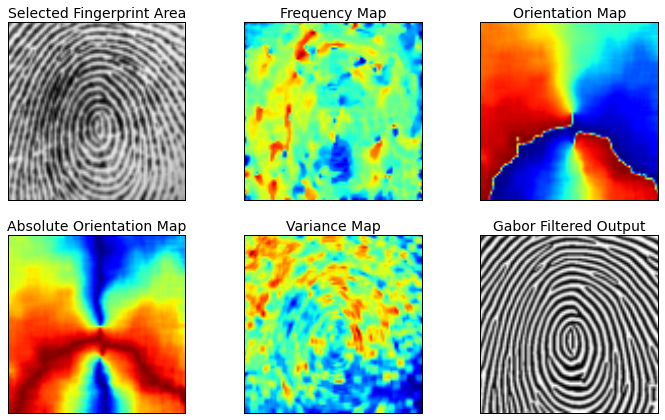

In [33]:
key = images_match_small.keys()[5]
f = plt.figure(figsize=(12,7))
ax = plt.subplot(2,3,1)
ax.imshow(images_match_small[key][:,:,0],cmap='gray')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('Selected Fingerprint Area', fontsize=14)
ax = plt.subplot(2,3,2)
ax.imshow(images_match_small[key][:,:,1],cmap='jet')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('Frequency Map', fontsize=14)
ax = plt.subplot(2,3,3)
ax.imshow(images_match_small[key][:,:,2],cmap='jet')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('Orientation Map', fontsize=14)
ax = plt.subplot(2,3,4)
ax.imshow(images_match_small[key][:,:,3],cmap='jet')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('Absolute Orientation Map', fontsize=14)
ax = plt.subplot(2,3,5)
ax.imshow(images_match_small[key][:,:,4],cmap='jet')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_title('Variance Map', fontsize=14)
ax = plt.subplot(2,3,6)
ax.imshow(images_match_small[key][:,:,5],cmap='gray')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);
ax.set_title('Gabor Filtered Output', fontsize=14)

f.savefig('demo.pdf')

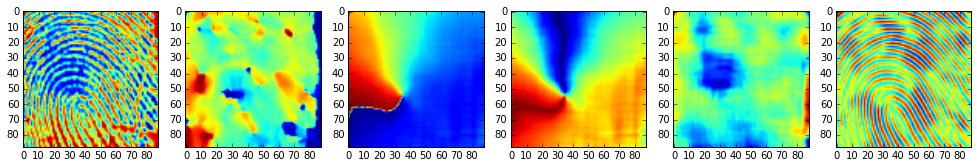

In [5]:
key = images_match.keys()[2]
plt.figure(figsize=(17,5))
for i in range(6):
    ax = plt.subplot(1,6,i+1)
    ax.imshow(images_match[key][:,:,i])

In [6]:
print 'There are %d pairs of matching finger prints, and %d pairs of mismatching finger prints' \
%(len(images_match.keys())/2, len(images_mismatch.keys())/2)

There are 2957 pairs of matching finger prints, and 983 pairs of mismatching finger prints


# Creating a new TF session and defining Shared Weights

In [7]:
# These two are input images
x = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])
x_p = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])

# y_ is just a value 0(match) or 1(no match) for the two input images
y_ = tf.placeholder(tf.float32, shape=[None, 1])

# Dropout coefficient
keep_prob = tf.placeholder(tf.float32)

# sess.run(tf.initialize_all_variables())

W_conv1 = weight_variable([7, 7, num_layer, num_filter_1])
b_conv1 = bias_variable([num_filter_1])

W_conv2 = weight_variable([5, 5, num_filter_1, num_filter_2])
b_conv2 = bias_variable([num_filter_2])

W_conv3 = weight_variable([5, 5, num_filter_2, num_filter_3])
b_conv3 = bias_variable([num_filter_3])

W_conv1_p = weight_variable([7, 7, num_layer, num_filter_1])
b_conv1_p = bias_variable([num_filter_1])

W_conv2_p = weight_variable([5, 5, num_filter_1, num_filter_2])
b_conv2_p = bias_variable([num_filter_2])

W_conv3_p = weight_variable([5, 5, num_filter_2, num_filter_3])
b_conv3_p = bias_variable([num_filter_3])

W_fc1 = weight_variable([image_size/8*image_size/8*num_filter_3, 1024])
b_fc1 = bias_variable([1024])

W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])

# Two Sides of Siamese Net

In [8]:
# ############### #
#      Side 1     #
# ############### #

# Input Image
x_image = tf.reshape(x, [-1,image_size,image_size,num_layer])

# First Conv Layer - after maxpool 44*44
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second Conv Layer - after maxpool 22*22
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Third Conv Layer - after maxpool 11*11
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# Final Data Processing Step
z = tf.reshape(h_pool3, [-1,image_size/8*image_size/8*num_filter_3])
# z = tf.reshape(h_pool3, [-1,4*4*256])
z_norm = tf.pow(tf.reduce_sum(tf.pow(z, 2), reduction_indices=1),0.5)

h_fc1 = tf.nn.relu(tf.matmul(z, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# ############### #
#      Side 2     #
# ############### #

# Input Image
x_image_p = tf.reshape(x_p, [-1,image_size,image_size,num_layer])

# First Conv Layer - after maxpool 44*44
h_conv1_p = tf.nn.relu(conv2d(x_image_p, W_conv1_p) + b_conv1_p)
h_pool1_p = max_pool_2x2(h_conv1_p)

# Second Conv Layer - after maxpool 22*22
h_conv2_p = tf.nn.relu(conv2d(h_pool1_p, W_conv2_p) + b_conv2_p)
h_pool2_p = max_pool_2x2(h_conv2_p)

# Third Conv Layer - after maxpool 11*11
h_conv3_p = tf.nn.relu(conv2d(h_pool2_p, W_conv3_p) + b_conv3_p)
h_pool3_p = max_pool_2x2(h_conv3_p)

# Final Data Processing Step
z_p = tf.reshape(h_pool3_p, [-1,image_size/8*image_size/8*num_filter_3])
# z_p = tf.reshape(h_pool3_p, [-1,4*4*256])
z_p_norm = tf.sqrt(tf.reduce_sum(tf.square(z_p), reduction_indices=1))

h_fc1_p = tf.nn.relu(tf.matmul(z_p, W_fc1) + b_fc1)
h_fc1_p_drop = tf.nn.dropout(h_fc1, keep_prob)

y_conv_p=tf.nn.softmax(tf.matmul(h_fc1_p_drop, W_fc2) + b_fc2)

# Actual Calculation

In [62]:
# Cosine
# distance = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)
abs_dist = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)
distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))
cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)

# Correlation Coefficient
# z_p_flat = tf.reshape(z_p, [tf.reduce_prod(tf.shape(z_p))])
# z_flat = tf.reshape(z, [tf.reduce_prod(tf.shape(z))])
# cross_entropy = tf.py_func(np.corrcoef, [z_p_flat, z_flat], [tf.float32])

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
sess = tf.InteractiveSession()

auc_list = []

saver = tf.train.Saver({"W1": W_conv1, "W2": W_conv2,"W3": W_conv3,
                        "b1": b_conv1,"b2": b_conv2,"b3": b_conv3,
                        "W1_p": W_conv1_p, "W2_p": W_conv2_p,"W3_p": W_conv3_p,
                        "b1_p": b_conv1_p,"b2_p": b_conv2_p,"b3_p": b_conv3_p,
                        "W_fc1": W_fc1, "b_fc1": b_fc1,
                        "W_fc2": W_fc2, "b_fc2": b_fc2})

init_op = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init_op)
    abs_dist = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)
    distance = tf.mul(tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm), tf.transpose(y_))
    cross_entropy = -tf.reduce_sum(distance, reduction_indices=1)
    sess.run(tf.initialize_all_variables())
    
    f = open('log.txt', 'w+')
    for i in range(5):
        batch = iF.generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 50, image_size, num_layer)

        if i%2 == 0:
            auc_batch = iF.generate_batch_pairs_from_preprocessed(images_match_small, images_mismatch_small, 50, image_size, num_layer)
            d =  abs_dist.eval(feed_dict={x:auc_batch[0], x_p:auc_batch[1], y_: auc_batch[2], keep_prob: 1.0})
            fpr, tpr, _ = roc_curve(auc_batch[2], d.T)
            roc_auc = auc(fpr, tpr)
            auc_list.append(roc_auc)
            str1 =  'Iteration '+ str(i) 
            str2 =  ' AUC: %.2f'%roc_auc+' Loss: '+str(cross_entropy.eval(feed_dict={x:auc_batch[0], x_p:auc_batch[1], y_: auc_batch[2], keep_prob: 1.0})[0])
            str3 =  ' Distance: '+str(((d[1:6]*100).astype(int)).astype(float)/100)+ ' Labels: '+ str((auc_batch[2][1:6].T).astype(int))
            save_path = saver.save(sess, "training"+str(i)+".ckpt")
            str4 = "Model saved in file: %s" % save_path
            
            
            f.write(str1 + str2+ str3 + '\n')
            f.write(str4+ '\n')
            
            f2 = open('progress.txt', 'w+')
            f2.write(str1 + str2+ str3 + '\n')
            f2.write(str4+ '\n')
            f2.close
            
        train_step.run(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
        
    f.close()

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1ce3a0bd0>> ignored


In [47]:
f = open('workfile.txt', 'w+')
for i in range(10):
    f.write('asdfhien'+str(i)+'\n')


for i in range(10):
    f.write('asn'+str(i)+'\n')
f.close()

In [44]:
from __future__ import print_function
print("hi there", file=f)

In [58]:
a = [ 0.51 0.53 0.5 0.52 0.53]
astr = str(a)
print(astr)

SyntaxError: invalid syntax (<ipython-input-58-737500cde8a1>, line 1)

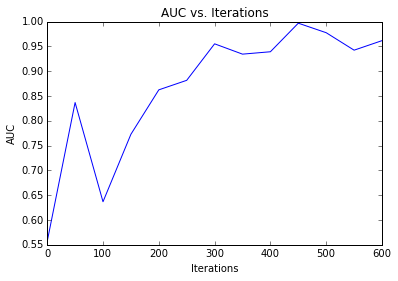

In [35]:
# plt.plot(np.linspace(0,600,13),auc_list)
# plt.title('AUC vs. Iterations')
# plt.xlabel('Iterations')
# plt.ylabel('AUC')

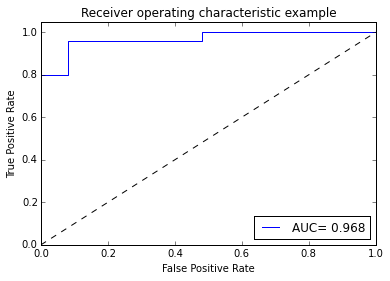

In [38]:
# auc_batch = iF.generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 50, image_size)
# d =  abs_dist.eval(feed_dict={x:auc_batch[0], x_p:auc_batch[1], y_: auc_batch[2], keep_prob: 1.0})
# fpr, tpr, _ = roc_curve(auc_batch[2], d.T)
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label='AUC= '+str(roc_auc))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")

In [34]:
# Correlation Coefficient
z_p_flat = tf.reshape(z_p, [tf.reduce_prod(tf.shape(z_p))])
z_flat = tf.reshape(z, [tf.reduce_prod(tf.shape(z))])
numerator = 50*(tf.reduce_sum(z_p_flat*z_flat)) - tf.reduce_sum(z_p_flat)*tf.reduce_sum(z_flat)
denominator = tf.sqrt((50*tf.reduce_sum(tf.square(z_p_flat)) - tf.square(tf.reduce_sum(z_p_flat)))*((50*tf.reduce_sum(tf.square(z_flat)) - tf.square(tf.reduce_sum(z_flat)))))
cross_entropy = numerator/denominator

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
sess = tf.InteractiveSession()

# sess = tf.Session()
sess.run(tf.initialize_all_variables())

for i in range(100):
    batch = iF.generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 50, image_size)
    
    
    if i%10 == 0:
        print cross_entropy.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
    
    
    train_step.run(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x11b5c0bd0>> ignored


-1.00023
-1.00045
-1.0007
-1.00098
-1.00131
-1.0017
-1.00209
-1.0025
-1.00316
-1.00395


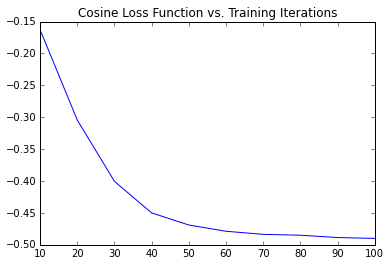

In [39]:
training_cosine = np.array([-8.14, -15.22, -20.03, -22.50, -23.45, -23.94, -24.18, -24.25, -24.43, -24.50])
iterations = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.plot(iterations, training_cosine/50)
plt.title('Cosine Loss Function vs. Training Iterations')

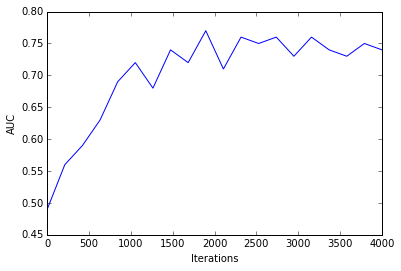

In [43]:
AUC_Curve = [0.49, 0.56, 0.59, 0.63, 0.69, 0.72, 0.68, 0.74, 0.72, 0.77, 0.71, 0.76, 0.75, 0.76, 0.73, 0.76, 0.74, 0.73, 0.75, 0.74]
plt.plot(np.linspace(0, 4000, 20),AUC_Curve)
plt.xlabel('Iterations')
plt.ylabel('AUC')

In [40]:
len(AUC_Curve)

19

# Below is the test on MNIST

In [ ]:
def generate_batch_mnist(n, mode='train'):
    x, x_p = np.zeros((n, 784)), np.zeros((n, 784))
    y = np.zeros((n,1))
    
    matched = 0
    mismatched = np.round(n/2)
    while matched < np.round(n/2):
        if mode == 'train':
            batch = mnist.train.next_batch(2, )
        elif mode == 'test':
            batch = mnist.test.next_batch(2)
        else:
            batch = mnist.validation.next_batch(2)
        
        if np.argmax(batch[1],axis=1)[0] == np.argmax(batch[1],axis=1)[1]:
            x[matched,:] = batch[0][0,:]
            x_p[matched,:] = batch[0][1,:]
            y[matched] = 1
            matched += 1
            
        elif mismatched > 0:
            x[-mismatched,:] = batch[0][0,:]
            x_p[-mismatched,:] = batch[0][1,:]
            mismatched -= 1
            
    return [x, x_p, y]

In [ ]:
batch = generate_batch_mnist(2)

for i in range(2):
    plt.figure()
    ax = plt.subplot(1,2,1)
    ax.imshow(np.reshape(batch[0][i,:],(28,28)))
    ax = plt.subplot(1,2,2)
    ax.imshow(np.reshape(batch[1][i,:],(28,28)))

In [ ]:
distance = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm) - tf.transpose(y_)
cross_entropy = tf.pow(tf.reduce_sum(tf.pow(distance, 2), reduction_indices=1),0.5)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

rounded = tf.round(cross_entropy*-1)
correct_prediction = tf.equal(rounded,tf.transpose(y_))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.initialize_all_variables())

for i in range(10000):
    mnist_batch = generate_batch_mnist(50, 'train')
    if i%500 == 0:
        c_e = cross_entropy.eval(feed_dict={x:mnist_batch[0], x_p:mnist_batch[1], y_: mnist_batch[2], keep_prob: 1.0})
        print c_e
#         print "Accuracy %g" %accuracy.eval(feed_dict={x:mnist_batch[0], x_p:mnist_batch[1], y_: mnist_batch[2], keep_prob: 1.0})

    train_step.run(feed_dict={x:mnist_batch[0], x_p:mnist_batch[1], y_: mnist_batch[2], keep_prob: 1.0})